In [1]:
# Installation

!pip install tensorflow
!pip install numpy==1.26.4 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 40.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
# Configuration

import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna.rt
    import sionna.phy
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)


In [2]:
# Imports

from sionna.phy.mapping import Mapper, Demapper, Constellation, BinarySource
from sionna.phy.utils import ebnodb2no
from sionna.phy.channel import AWGN
from sionna.phy.ofdm import OFDMModulator, OFDMDemodulator
from sionna.phy import Block
from sionna.phy.ofdm import ResourceGrid, PilotPattern, OFDMModulator, OFDMDemodulator, ResourceGridMapper, ResourceGridDemapper
import numpy as np
import matplotlib.pyplot as plt
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies


In [3]:
# Uploading .xml files built in Blender

from google.colab import files
uploaded = files.upload()


Saving ufo.zip to ufo.zip


In [4]:
# Unzipping

import zipfile
import os

# Creating a folder named "Hedef" and storing the files

zip_file = "ufo.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
  zip_ref.extractall("hedef")

# List
os.listdir("hedef/ufo/properscene/deneme")



['meshes', 'floatingcube.xml', 'sphere.xml', 'floatingsphere.xml']

In [5]:
# Loading a scene

scene_basic = load_scene("hedef/ufo/properscene/deneme/sphere.xml",merge_shapes=False)


In [6]:
# Configuring Tx and Rxs

scene_basic.tx_array = PlanarArray(num_rows = 1,
                            num_cols = 1,
                            vertical_spacing = 0.5,
                            horizontal_spacing = 0.5,
                            pattern = "iso",
                            polarization = "H")

scene_basic.rx_array = PlanarArray(num_rows = 1,
                            num_cols = 1,
                            vertical_spacing = 0.5,
                            horizontal_spacing = 0.5,
                            pattern = "iso",
                            polarization = "H")

In [7]:
# 3+ TX version

# Always remove before adding

scene_basic.remove("tx1")
scene_basic.remove("tx2")
scene_basic.remove("tx3")
scene_basic.remove("tx4")
scene_basic.remove("tx5")
scene_basic.remove("rx1")


# Locations indexed from anten_location list
# Orientations do not matter because there is a single antenna and its isotropic

anten_location = [[[-200, 200, 15], [0, 200, 20]],
                  [[250, -250, 20], [0, 200, 20]],
                  [[-400, 100, 30], [0, 200, 20]],
                  [[250, -250, 25], [0, 200, 20]],
                  [[500, 0, 30], [0, 200, 20]],
                  [[-300, 0, 20], [0, 200, 20]]]


tx1 = Transmitter("tx1", anten_location[0][0], anten_location[1][1])
scene_basic.add(tx1)

tx2 = Transmitter("tx2", anten_location[1][0], anten_location[0][1])
scene_basic.add(tx2)

tx3 = Transmitter("tx3", anten_location[2][0], anten_location[1][1])
scene_basic.add(tx3)

tx4 = Transmitter("tx4", anten_location[3][0], anten_location[0][1])
scene_basic.add(tx4)

tx5 = Transmitter("tx5", anten_location[4][0], anten_location[1][1])
scene_basic.add(tx5)

rx1 = Receiver("rx1", anten_location[5][0], anten_location[0][1])
scene_basic.add(rx1)

# Adjusting the powers, irrelevant
'''
tx1.power_dbm = 120
tx2.power_dbm = 120
tx3.power_dbm = 120
tx4.power_dbm = 120
tx5.power_dbm = 120
'''

'\ntx1.power_dbm = 120\ntx2.power_dbm = 120\ntx3.power_dbm = 120\ntx4.power_dbm = 120\ntx5.power_dbm = 120\n'

In [8]:
# Instantiate a path solver
# The same path solver can be used with multiple scenes

p_solver  = PathSolver()
scene_basic.get("Icosphere").radio_material.scattering_coefficient = 0.5
scene_object = scene_basic.get("Icosphere")
print(scene_object.position) # To learn the exact position
paths = p_solver(scene=scene_basic,
                 max_depth=1,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=True,
                 refraction=True,
                 samples_per_src=10**8,
                 seed=46)


[[0, 0, 300]]


In [9]:
# Path info's

a, tau = paths.cir(normalize_delays=False, out_type="numpy")
tau[tau == -1.0] = 0.0
print("a: ", a)
print("tau: ", tau)


a:  [[[[[[-8.5876190e-06+2.9240409e-05j]
     [-7.9088028e-11-1.2540270e-09j]
     [-1.2014091e-09+3.6494174e-10j]
     ...
     [ 1.3178344e-09+1.6001391e-09j]
     [ 4.6060289e-10+2.0207505e-09j]
     [ 2.4125086e-09+5.8351657e-10j]]]


   [[[ 4.9538362e-06+1.0136515e-05j]
     [ 6.0221617e-10-2.4428382e-09j]
     [-1.5831181e-09+1.9491471e-09j]
     ...
     [ 0.0000000e+00+0.0000000e+00j]
     [ 0.0000000e+00+0.0000000e+00j]
     [ 0.0000000e+00+0.0000000e+00j]]]


   [[[-2.0306183e-05+4.3579035e-05j]
     [ 6.2345751e-10-1.2903976e-10j]
     [-1.6700756e-10+6.1741379e-10j]
     ...
     [ 0.0000000e+00+0.0000000e+00j]
     [ 0.0000000e+00+0.0000000e+00j]
     [ 0.0000000e+00+0.0000000e+00j]]]


   [[[ 1.0376688e-05-4.4277540e-06j]
     [-8.4619395e-10+2.5343488e-10j]
     [-7.2357192e-10-5.0926019e-10j]
     ...
     [ 0.0000000e+00+0.0000000e+00j]
     [ 0.0000000e+00+0.0000000e+00j]
     [ 0.0000000e+00+0.0000000e+00j]]]


   [[[ 8.4196599e-06-1.3010392e-06j]
     [ 9.1224271e-1

In [10]:
# Sampling

sample_rate = 61.44*1e6
t0 = np.floor(tau[0][0][:]*sample_rate) # Scale to ns
t1 = np.floor(tau[0][1][:]*sample_rate)
t2 = np.floor(tau[0][2][:]*sample_rate)
t3 = np.floor(tau[0][3][:]*sample_rate)
t4 = np.floor(tau[0][4][:]*sample_rate)
abs0 = np.abs(a)[0, 0, 0, 0, :]  # Magnitude array
abs1 = np.abs(a)[0, 0, 1, 0, :]
abs2 = np.abs(a)[0, 0, 2, 0, :]
abs3 = np.abs(a)[0, 0, 3, 0, :]
abs4 = np.abs(a)[0, 0, 4, 0, :]

time_array = [t0,t1,t2, t3, t4]
abs_array = [abs0,abs1,abs2, abs3, abs4]

unique_samples_list = []
summed_magnitudes_list = []

# Enumerate for each one
for idx, (t, a_abs) in enumerate(zip(time_array, abs_array)):
    unique_sample = np.unique(t)
    summed_magnitudes = np.zeros_like(unique_sample, dtype=float)

    for i, sample_val in enumerate(unique_sample):
        summed_magnitudes[i] = np.sum(a_abs[t == sample_val])

    unique_samples_list.append(unique_sample)
    summed_magnitudes_list.append(summed_magnitudes)


In [11]:
# Printing for early inspection

for path_idx in range(len(unique_samples_list)):
    unique_sample = unique_samples_list[path_idx]
    summed_magnitudes = summed_magnitudes_list[path_idx]

    print(f"\n--- Path {path_idx+1} ---")
    for i in range(len(unique_sample)):
        print(f"{i+1}. sample -- t: {unique_sample[i]}, abs: {summed_magnitudes[i]}")


--- Path 1 ---
1. sample -- t: 45.0, abs: 3.0475377570837736e-05
2. sample -- t: 162.0, abs: 2.016938196902629e-06
3. sample -- t: 163.0, abs: 3.976575499109458e-06
4. sample -- t: 164.0, abs: 1.9327694644744042e-06
5. sample -- t: 165.0, abs: 4.896307927992893e-07
6. sample -- t: 166.0, abs: 3.876236931432686e-08

--- Path 2 ---
1. sample -- t: 0.0, abs: 0.0
2. sample -- t: 123.0, abs: 1.1282261766609736e-05
3. sample -- t: 173.0, abs: 7.840521902835462e-07
4. sample -- t: 174.0, abs: 1.7250229120691074e-06
5. sample -- t: 175.0, abs: 2.3141771521295595e-07
6. sample -- t: 176.0, abs: 3.072085164035343e-08

--- Path 3 ---
1. sample -- t: 0.0, abs: 0.0
2. sample -- t: 29.0, abs: 4.8077781684696674e-05
3. sample -- t: 181.0, abs: 2.7085338842880446e-06
4. sample -- t: 182.0, abs: 2.1769678824057337e-06
5. sample -- t: 183.0, abs: 1.084255472960649e-06
6. sample -- t: 184.0, abs: 2.3056489339978725e-07
7. sample -- t: 185.0, abs: 2.1157209317834713e-08

--- Path 4 ---
1. sample -- t: 0.

In [12]:
# Deriving Channel Impulse Responses using Samples

h_list = []  # to store h1, h2, h3

for path_idx in range(len(unique_samples_list)):
    unique_sample = unique_samples_list[path_idx].astype(int)
    summed_magnitudes = summed_magnitudes_list[path_idx]

    # Define CIR array length
    channel_length = unique_sample.max() + 10  # leave some margin
    cir = np.zeros(channel_length)

    # Fill CIR
    for i, d in enumerate(unique_sample):
        cir[d] += summed_magnitudes[i]

    h_list.append(cir)  # store CIR

# Now extract individually:
h1, h2, h3, h4, h5 = h_list[0], h_list[1], h_list[2], h_list[3], h_list[4]


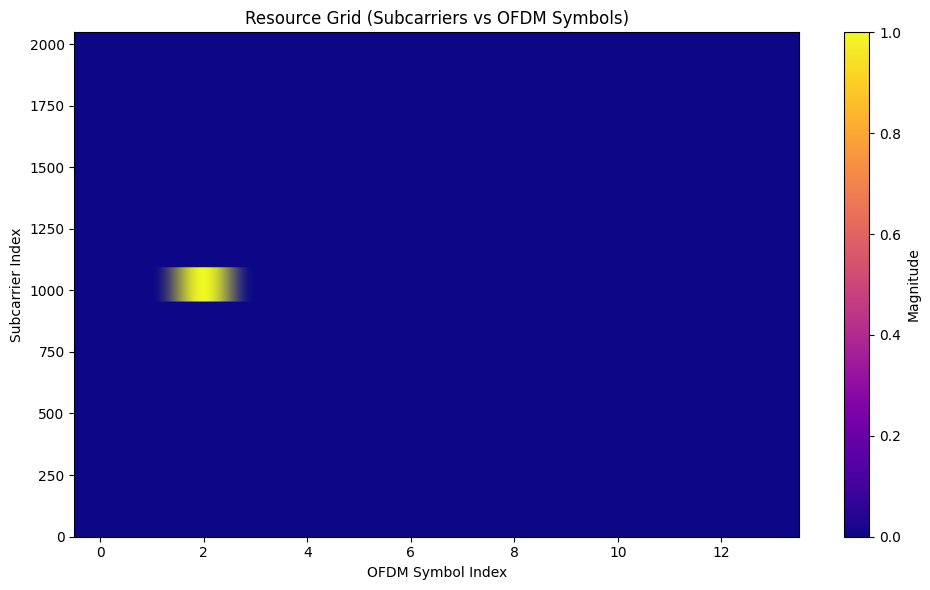

In [13]:
# Preamble #1

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sionna.phy.ofdm import ResourceGrid, OFDMModulator

# ------------------ Step 1: Zadoff-Chu Sequence ------------------ #
u1 = 129          # Root index (coprime with N_zc)
N_zc1 = 139       # PRACH sequence length
N_cs1 = 13        # Cyclic shift (we'll use v = 0)
v1 = 0
C_v1 = v1 * N_cs1

n1 = np.arange(N_zc1)
zc_seq1 = np.exp(-1j * np.pi * u1 * n1 * (n1 + 1) / N_zc1)
zc_shifted1 = np.roll(zc_seq1, C_v1)
zc_tf1 = tf.convert_to_tensor(zc_shifted1, dtype=tf.complex64)

# ------------------ Step 2: Resource Grid Parameters ------------------ #
num_tx1 = 1
fft_size1 = 2048
cp_length1 = 158
num_ofdm_symbols1 = 14
subcarrier_spacing1 = 30e3

# Create resource grid object (for parameter sharing only)
rg = ResourceGrid(num_tx=num_tx1,
                  fft_size=fft_size1,
                  cyclic_prefix_length=cp_length1,
                  num_ofdm_symbols=num_ofdm_symbols1,
                  subcarrier_spacing=subcarrier_spacing1)

# ------------------ Step 3: Map to PRACH symbols (2–13) ------------------ #
left_pad1 = fft_size1 // 2 - (N_zc1 // 2)
right_pad1 = fft_size1 - (left_pad1 + N_zc1)


# Build padded ZC sequence
padded_zc1 = tf.concat([
    tf.zeros([left_pad1], dtype=tf.complex64),
    zc_tf1,
    tf.zeros([right_pad1], dtype=tf.complex64)
], axis=0)

# Initialize entire grid with zeros
grid_freq1 = tf.zeros([1, num_tx1, num_ofdm_symbols1, fft_size1], dtype=tf.complex64)

# Fill symbols 2 to 5 with the ZC pulse
for sym in range(2, 3):
    grid_freq1 = tf.tensor_scatter_nd_update(
        grid_freq1,
        indices=[[0, 0, sym]],
        updates=[padded_zc1]
    )

# ------------------ Step 4: OFDM Modulation ------------------ #
modulator = OFDMModulator(
    fft_size=fft_size1,
    subcarrier_spacing=subcarrier_spacing1,
    cyclic_prefix_length=cp_length1,
    num_ofdm_symbols=num_ofdm_symbols1,
    num_tx=num_tx1
)
tx_time1 = modulator(grid_freq1)
x_t1 = tx_time1[0, 0, :].numpy()


# ------------------ Step 5: Plot Resource Grid ------------------ #
grid_mag1 = tf.abs(grid_freq1[0, 0, :, :])  # [symbols, subcarriers]

plt.figure(figsize=(10, 6))
plt.imshow(grid_mag1.numpy().T, aspect='auto', origin='lower', cmap='plasma')
plt.colorbar(label="Magnitude")
plt.title("Resource Grid (Subcarriers vs OFDM Symbols)")
plt.xlabel("OFDM Symbol Index")
plt.ylabel("Subcarrier Index")
plt.tight_layout()
plt.show()


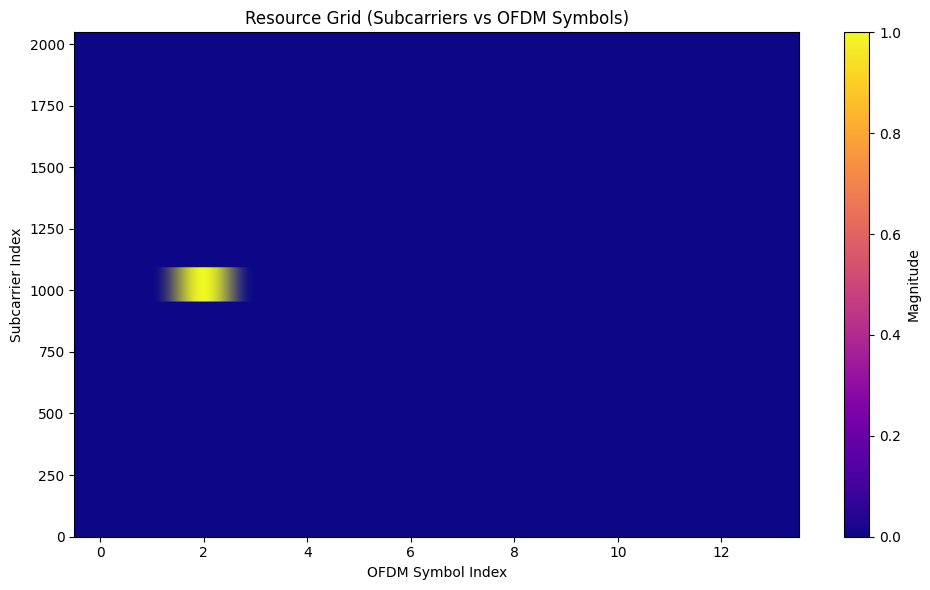

In [14]:
# Preamble #2

# ------------------ Step 1: Zadoff-Chu Sequence ------------------ #
u2 = 107          # Root index (coprime with N_zc)
N_zc2 = 139       # PRACH sequence length
N_cs2 = 14        # Cyclic shift (we'll use v = 0)
v2 = 0
C_v2 = v2 * N_cs2

n2 = np.arange(N_zc2)
zc_seq2 = np.exp(-1j * np.pi * u2 * n2 * (n2 + 1) / N_zc2)
zc_shifted2 = np.roll(zc_seq2, C_v2)
zc_tf2 = tf.convert_to_tensor(zc_shifted2, dtype=tf.complex64)

# ------------------ Step 2: Resource Grid Parameters ------------------ #
num_tx2 = 1
fft_size2 = 2048
cp_length2 = 158
num_ofdm_symbols2 = 14
subcarrier_spacing2 = 30e3

# Create resource grid object (for parameter sharing only)
rg2 = ResourceGrid(num_tx=num_tx2,
                  fft_size=fft_size2,
                  cyclic_prefix_length=cp_length2,
                  num_ofdm_symbols=num_ofdm_symbols2,
                  subcarrier_spacing=subcarrier_spacing2)

# ------------------ Step 3: Map to PRACH symbols (2–13) ------------------ #
left_pad2 = fft_size2 // 2 - (N_zc2 // 2)
right_pad2 = fft_size2 - (left_pad2 + N_zc2)


# Build padded ZC sequence
padded_zc2 = tf.concat([
    tf.zeros([left_pad2], dtype=tf.complex64),
    zc_tf2,
    tf.zeros([right_pad2], dtype=tf.complex64)
], axis=0)

# Initialize entire grid with zeros
grid_freq2 = tf.zeros([1, num_tx2, num_ofdm_symbols2, fft_size2], dtype=tf.complex64)

# Fill symbols 2 to 5 with the ZC pulse
for sym in range(2, 3):
    grid_freq2 = tf.tensor_scatter_nd_update(
        grid_freq2,
        indices=[[0, 0, sym]],
        updates=[padded_zc2]
    )

# ------------------ Step 4: OFDM Modulation ------------------ #
modulator = OFDMModulator(
    fft_size=fft_size2,
    subcarrier_spacing=subcarrier_spacing2,
    cyclic_prefix_length=cp_length2,
    num_ofdm_symbols=num_ofdm_symbols2,
    num_tx=num_tx2
)
tx_time2 = modulator(grid_freq2)
x_t2 = tx_time2[0, 0, :].numpy()


# ------------------ Step 5: Plot Resource Grid ------------------ #
grid_mag2 = tf.abs(grid_freq2[0, 0, :, :])  # [symbols, subcarriers]

plt.figure(figsize=(10, 6))
plt.imshow(grid_mag2.numpy().T, aspect='auto', origin='lower', cmap='plasma')
plt.colorbar(label="Magnitude")
plt.title("Resource Grid (Subcarriers vs OFDM Symbols)")
plt.xlabel("OFDM Symbol Index")
plt.ylabel("Subcarrier Index")
plt.tight_layout()
plt.show()


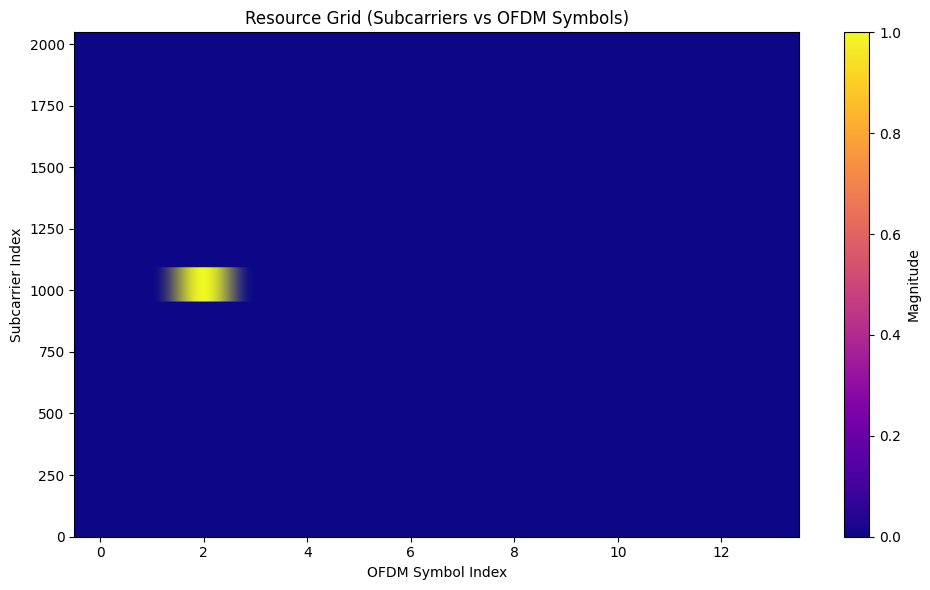

In [15]:
# Preamble #3

# ------------------ Step 1: Zadoff-Chu Sequence ------------------ #
u3 = 97          # Root index (coprime with N_zc)
N_zc3 = 139       # PRACH sequence length
N_cs3 = 13        # Cyclic shift (we'll use v = 0)
v3 = 0
C_v3 = v3 * N_cs3

n3 = np.arange(N_zc3)
zc_seq3 = np.exp(-1j * np.pi * u3 * n3 * (n3 + 1) / N_zc3)
zc_shifted3 = np.roll(zc_seq3, C_v3)
zc_tf3 = tf.convert_to_tensor(zc_shifted3, dtype=tf.complex64)

# ------------------ Step 2: Resource Grid Parameters ------------------ #
num_tx3 = 1
fft_size3 = 2048
cp_length3 = 158
num_ofdm_symbols3 = 14
subcarrier_spacing3 = 30e3

# Create resource grid object (for parameter sharing only)
rg3 = ResourceGrid(num_tx=num_tx3,
                  fft_size=fft_size3,
                  cyclic_prefix_length=cp_length3,
                  num_ofdm_symbols=num_ofdm_symbols3,
                  subcarrier_spacing=subcarrier_spacing3)

# ------------------ Step 3: Map to PRACH symbols (2–13) ------------------ #
left_pad3 = fft_size3 // 2 - (N_zc3 // 2)
right_pad3 = fft_size3 - (left_pad3 + N_zc3)


# Build padded ZC sequence
padded_zc3 = tf.concat([
    tf.zeros([left_pad3], dtype=tf.complex64),
    zc_tf3,
    tf.zeros([right_pad3], dtype=tf.complex64)
], axis=0)

# Initialize entire grid with zeros
grid_freq3 = tf.zeros([1, num_tx3, num_ofdm_symbols3, fft_size3], dtype=tf.complex64)

# Fill symbols 2 to 5 with the ZC pulse
for sym in range(2, 3):
    grid_freq3 = tf.tensor_scatter_nd_update(
        grid_freq3,
        indices=[[0, 0, sym]],
        updates=[padded_zc3]
    )

# ------------------ Step 4: OFDM Modulation ------------------ #
modulator = OFDMModulator(
    fft_size=fft_size3,
    subcarrier_spacing=subcarrier_spacing3,
    cyclic_prefix_length=cp_length3,
    num_ofdm_symbols=num_ofdm_symbols3,
    num_tx=num_tx3
)
tx_time3 = modulator(grid_freq3)
x_t3 = tx_time3[0, 0, :].numpy()


# ------------------ Step 5: Plot Resource Grid ------------------ #
grid_mag3 = tf.abs(grid_freq3[0, 0, :, :])  # [symbols, subcarriers]

plt.figure(figsize=(10, 6))
plt.imshow(grid_mag3.numpy().T, aspect='auto', origin='lower', cmap='plasma')
plt.colorbar(label="Magnitude")
plt.title("Resource Grid (Subcarriers vs OFDM Symbols)")
plt.xlabel("OFDM Symbol Index")
plt.ylabel("Subcarrier Index")
plt.tight_layout()
plt.show()


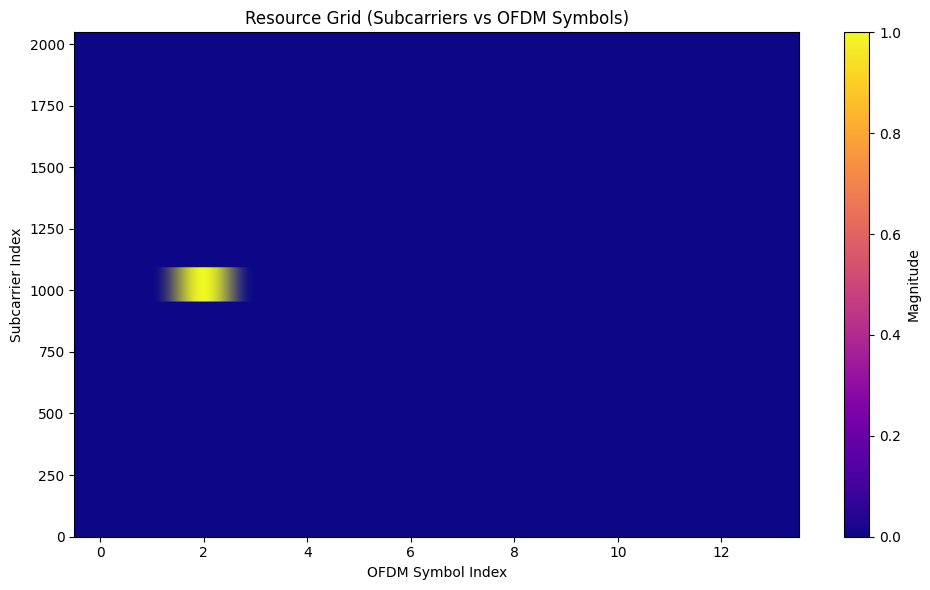

In [16]:
# Preamble #4

# ------------------ Step 1: Zadoff-Chu Sequence ------------------ #
u4 = 103          # Root index (coprime with N_zc)
N_zc4 = 139       # PRACH sequence length
N_cs4 = 13        # Cyclic shift (we'll use v = 0)
v4 = 0
C_v4 = v4 * N_cs4

n4 = np.arange(N_zc4)
zc_seq4 = np.exp(-1j * np.pi * u4 * n4 * (n4 + 1) / N_zc4)
zc_shifted4 = np.roll(zc_seq4, C_v4)
zc_tf4 = tf.convert_to_tensor(zc_shifted4, dtype=tf.complex64)

# ------------------ Step 2: Resource Grid Parameters ------------------ #
num_tx4 = 1
fft_size4 = 2048
cp_length4 = 158
num_ofdm_symbols4 = 14
subcarrier_spacing4 = 30e3

# Create resource grid object (for parameter sharing only)
rg4 = ResourceGrid(num_tx=num_tx4,
                  fft_size=fft_size4,
                  cyclic_prefix_length=cp_length4,
                  num_ofdm_symbols=num_ofdm_symbols4,
                  subcarrier_spacing=subcarrier_spacing4)

# ------------------ Step 3: Map to PRACH symbols (2–13) ------------------ #
left_pad4 = fft_size4 // 2 - (N_zc4 // 2)
right_pad4 = fft_size4 - (left_pad4 + N_zc4)


# Build padded ZC sequence
padded_zc4 = tf.concat([
    tf.zeros([left_pad4], dtype=tf.complex64),
    zc_tf3,
    tf.zeros([right_pad4], dtype=tf.complex64)
], axis=0)

# Initialize entire grid with zeros
grid_freq4 = tf.zeros([1, num_tx4, num_ofdm_symbols4, fft_size4], dtype=tf.complex64)

# Fill symbols 2 to 5 with the ZC pulse
for sym in range(2, 3):
    grid_freq4 = tf.tensor_scatter_nd_update(
        grid_freq4,
        indices=[[0, 0, sym]],
        updates=[padded_zc4]
    )

# ------------------ Step 4: OFDM Modulation ------------------ #
modulator = OFDMModulator(
    fft_size=fft_size4,
    subcarrier_spacing=subcarrier_spacing4,
    cyclic_prefix_length=cp_length4,
    num_ofdm_symbols=num_ofdm_symbols4,
    num_tx=num_tx4
)
tx_time4 = modulator(grid_freq4)
x_t4 = tx_time4[0, 0, :].numpy()


# ------------------ Step 5: Plot Resource Grid ------------------ #
grid_mag4 = tf.abs(grid_freq4[0, 0, :, :])  # [symbols, subcarriers]

plt.figure(figsize=(10, 6))
plt.imshow(grid_mag4.numpy().T, aspect='auto', origin='lower', cmap='plasma')
plt.colorbar(label="Magnitude")
plt.title("Resource Grid (Subcarriers vs OFDM Symbols)")
plt.xlabel("OFDM Symbol Index")
plt.ylabel("Subcarrier Index")
plt.tight_layout()
plt.show()


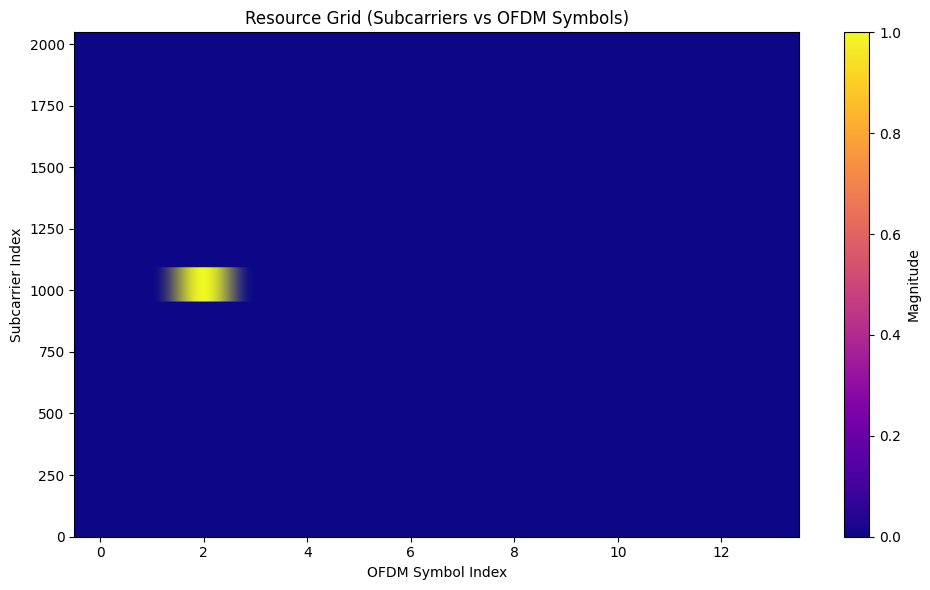

In [17]:
# Preamble #5

# ------------------ Step 1: Zadoff-Chu Sequence ------------------ #
u5 = 101          # Root index (coprime with N_zc)
N_zc5 = 139      # PRACH sequence length
N_cs5 = 13       # Cyclic shift (we'll use v = 0)
v5 = 0
C_v5 = v5 * N_cs5

n5 = np.arange(N_zc5)
zc_seq5 = np.exp(-1j * np.pi * u5 * n5 * (n5 + 1) / N_zc5)
zc_shifted5 = np.roll(zc_seq5, C_v5)
zc_tf5 = tf.convert_to_tensor(zc_shifted5, dtype=tf.complex64)

# ------------------ Step 2: Resource Grid Parameters ------------------ #
num_tx5 = 1
fft_size5 = 2048
cp_length5 = 158
num_ofdm_symbols5 = 14
subcarrier_spacing5 = 30e3

# Create resource grid object (for parameter sharing only)
rg5 = ResourceGrid(num_tx=num_tx5,
                   fft_size=fft_size5,
                   cyclic_prefix_length=cp_length5,
                   num_ofdm_symbols=num_ofdm_symbols5,
                   subcarrier_spacing=subcarrier_spacing5)

# ------------------ Step 3: Map to PRACH symbols (2–13) ------------------ #
left_pad5 = fft_size5 // 2 - (N_zc5 // 2)
right_pad5 = fft_size5 - (left_pad5 + N_zc5)

# Build padded ZC sequence
padded_zc5 = tf.concat([
    tf.zeros([left_pad5], dtype=tf.complex64),
    zc_tf5,
    tf.zeros([right_pad5], dtype=tf.complex64)
], axis=0)

# Initialize entire grid with zeros
grid_freq5 = tf.zeros([1, num_tx5, num_ofdm_symbols5, fft_size5], dtype=tf.complex64)

# Fill symbols 2 to 5 with the ZC pulse
for sym in range(2, 3):
    grid_freq5 = tf.tensor_scatter_nd_update(
        grid_freq5,
        indices=[[0, 0, sym]],
        updates=[padded_zc5]
    )

# ------------------ Step 4: OFDM Modulation ------------------ #
modulator = OFDMModulator(
    fft_size=fft_size5,
    subcarrier_spacing=subcarrier_spacing5,
    cyclic_prefix_length=cp_length5,
    num_ofdm_symbols=num_ofdm_symbols5,
    num_tx=num_tx5
)
tx_time5 = modulator(grid_freq5)
x_t5 = tx_time5[0, 0, :].numpy()

# ------------------ Step 5: Plot Resource Grid ------------------ #
grid_mag5 = tf.abs(grid_freq5[0, 0, :, :])  # [symbols, subcarriers]

plt.figure(figsize=(10, 6))
plt.imshow(grid_mag5.numpy().T, aspect='auto', origin='lower', cmap='plasma')
plt.colorbar(label="Magnitude")
plt.title("Resource Grid (Subcarriers vs OFDM Symbols)")
plt.xlabel("OFDM Symbol Index")
plt.ylabel("Subcarrier Index")
plt.tight_layout()
plt.show()


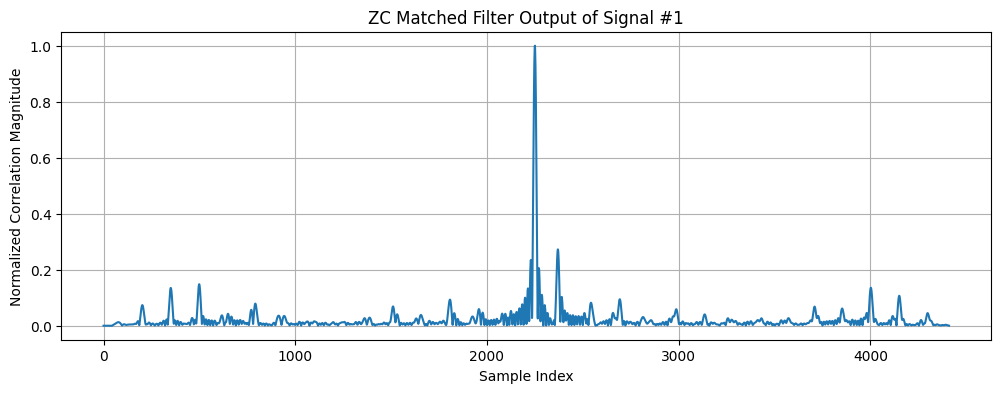

In [18]:
# Transmit through channel (tx1-rx1)

y_t1 = np.convolve(x_t1, h1, mode='full')[:len(x_t1)]

sym_len = fft_size1 + cp_length1

# Extracting the relevant part

start = 2 * sym_len
end = 3 * sym_len

zc_only_tx1 = x_t1[start:end]
zc_only_rx1 = y_t1[start:end]  # same segment from received signal


# ZC Matched Filter Correlation (Time Domain)

zc_corr1 = np.correlate(zc_only_rx1, zc_only_tx1, mode='full')
zc_corr_abs1 = np.abs(zc_corr1)
zc_corr_abs1 = zc_corr_abs1 / np.max(zc_corr_abs1)

# Plot correlation

plt.figure(figsize=(12, 4))
plt.plot(zc_corr_abs1)
plt.title("ZC Matched Filter Output of Signal #1")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Correlation Magnitude")
plt.grid(True)
plt.show()



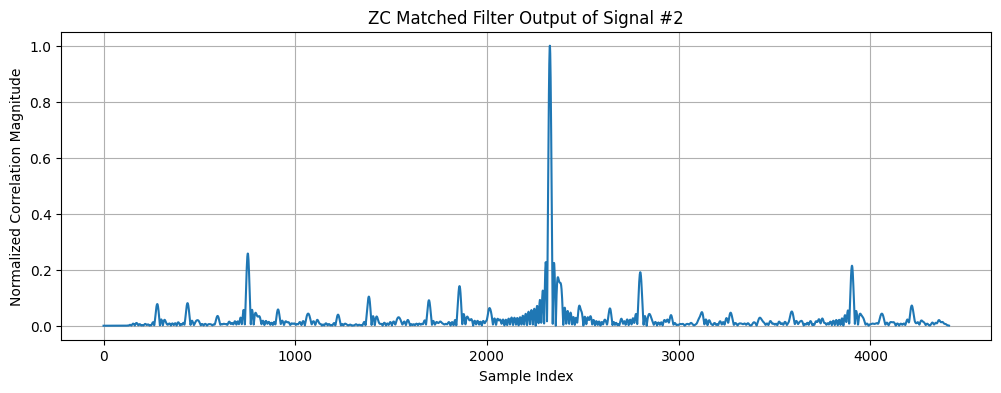

In [19]:
#  Transmit through channel (tx2-rx1)

y_t2 = np.convolve(x_t2, h2, mode='full')[:len(x_t2)]

sym_len = fft_size2 + cp_length2

# Extracting the relevant part

start = 2 * sym_len
end = 3 * sym_len

zc_only_tx2 = x_t2[start:end]
zc_only_rx2= y_t2[start:end]  # same segment from received signal


#  ZC Matched Filter Correlation (Time Domain)

zc_corr2 = np.correlate(zc_only_rx2, zc_only_tx2, mode='full')
zc_corr_abs2 = np.abs(zc_corr2)
zc_corr_abs2 = zc_corr_abs2 / np.max(zc_corr_abs2)

# Plot correlation

plt.figure(figsize=(12, 4))
plt.plot(zc_corr_abs2)
plt.title("ZC Matched Filter Output of Signal #2")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Correlation Magnitude")
plt.grid(True)
plt.show()


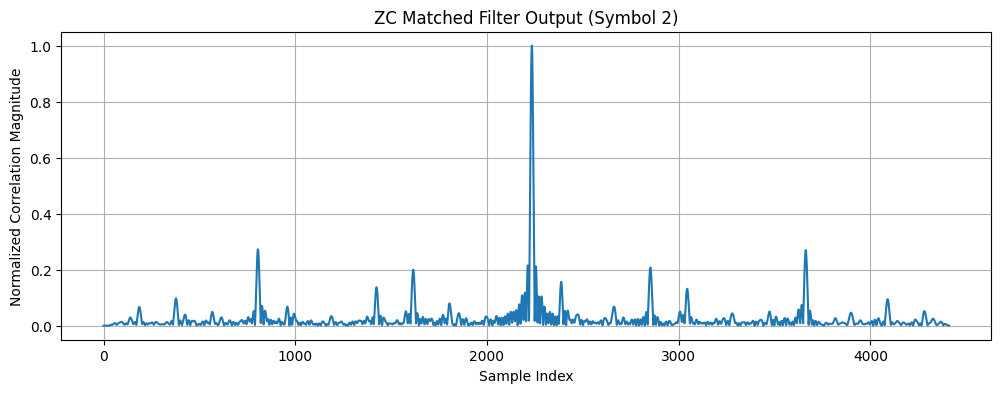

In [20]:
# Transmit through channel (tx3-rx1)

y_t3 = np.convolve(x_t3, h3, mode='full')[:len(x_t3)]

sym_len = fft_size3 + cp_length3

# Extracting the relevant part

start = 2 * sym_len
end = 3 * sym_len

zc_only_tx3 = x_t3[start:end]
zc_only_rx3 = y_t3[start:end]  # same segment from received signal


#  ZC Matched Filter Correlation (Time Domain)

zc_corr3 = np.correlate(zc_only_rx3, zc_only_tx3, mode='full')
zc_corr_abs3 = np.abs(zc_corr3)
zc_corr_abs3 = zc_corr_abs3 / np.max(zc_corr_abs3)

# Plot correlation

plt.figure(figsize=(12, 4))
plt.plot(zc_corr_abs3)
plt.title("ZC Matched Filter Output (Symbol 2)")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Correlation Magnitude")
plt.grid(True)
plt.show()


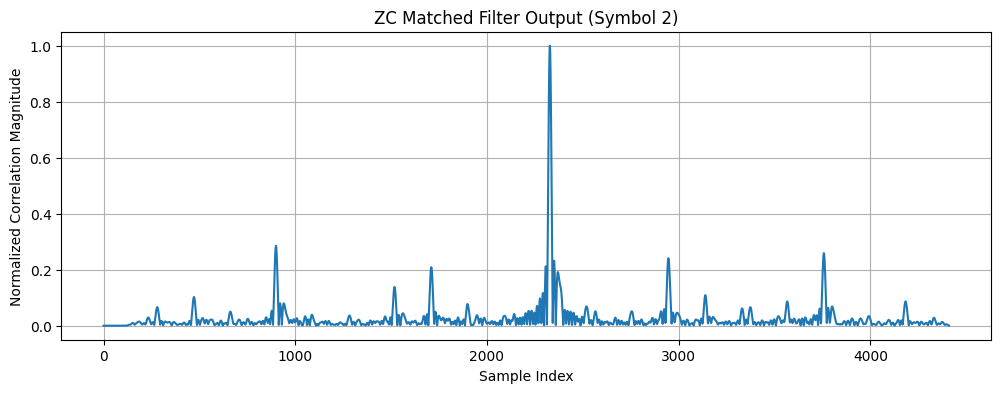

In [21]:
# Transmit through channel (tx4-rx1)

y_t4 = np.convolve(x_t4, h4, mode='full')[:len(x_t4)]

sym_len = fft_size4 + cp_length4

# Extracting the relevant part

start = 2 * sym_len
end = 3 * sym_len

zc_only_tx4 = x_t4[start:end]
zc_only_rx4 = y_t4[start:end]  # same segment from received signal


#  ZC Matched Filter Correlation (Time Domain)

zc_corr4 = np.correlate(zc_only_rx4, zc_only_tx4, mode='full')
zc_corr_abs4 = np.abs(zc_corr4)
zc_corr_abs4 = zc_corr_abs4 / np.max(zc_corr_abs4)

# Plot correlation

plt.figure(figsize=(12, 4))
plt.plot(zc_corr_abs4)
plt.title("ZC Matched Filter Output (Symbol 2)")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Correlation Magnitude")
plt.grid(True)
plt.show()


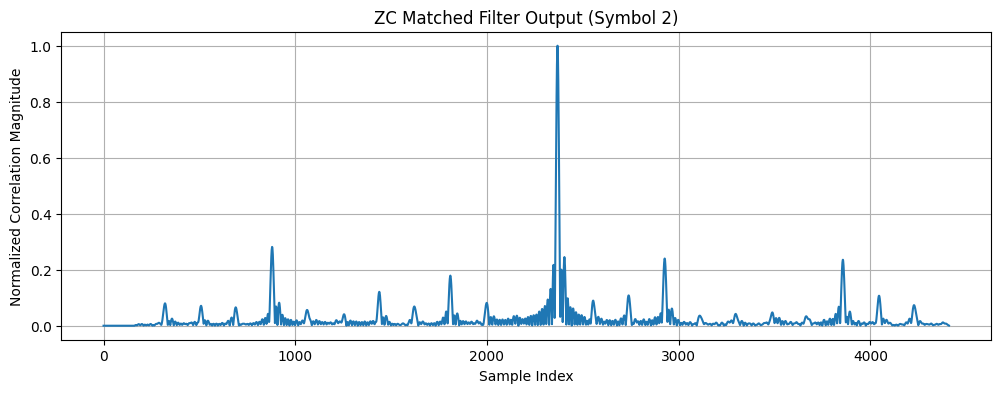

In [22]:
# Transmit through channel (tx5-rx1)

y_t5 = np.convolve(x_t5, h5, mode='full')[:len(x_t5)]

sym_len = fft_size5 + cp_length5

# Extracting the relevant part

start = 2 * sym_len
end = 3 * sym_len

zc_only_tx5 = x_t5[start:end]
zc_only_rx5 = y_t5[start:end]  # same segment from received signal


#  ZC Matched Filter Correlation (Time Domain)

zc_corr5 = np.correlate(zc_only_rx5, zc_only_tx5, mode='full')
zc_corr_abs5 = np.abs(zc_corr5)
zc_corr_abs5 = zc_corr_abs5 / np.max(zc_corr_abs5)

# Plot correlation

plt.figure(figsize=(12, 4))
plt.plot(zc_corr_abs5)
plt.title("ZC Matched Filter Output (Symbol 2)")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Correlation Magnitude")
plt.grid(True)
plt.show()


In [23]:
# Peak Detection Algorithm

import numpy as np
from scipy.signal import find_peaks

def find_largest_two_peaks(signal, zc_length):
    max_idx = np.argmax(signal)
    frame1 = signal[max_idx - 2 : max_idx + int(zc_length/10)]
    peaks, _ = find_peaks(frame1, distance= 27)
    if len(peaks) == 0:
        return np.array([], dtype=int)
    top_two = np.sort(peaks[np.argsort(frame1[peaks])[::-1][:2]])
    print(int(max_idx), max_idx + int(zc_length/10))
    return max_idx + top_two


400 3488


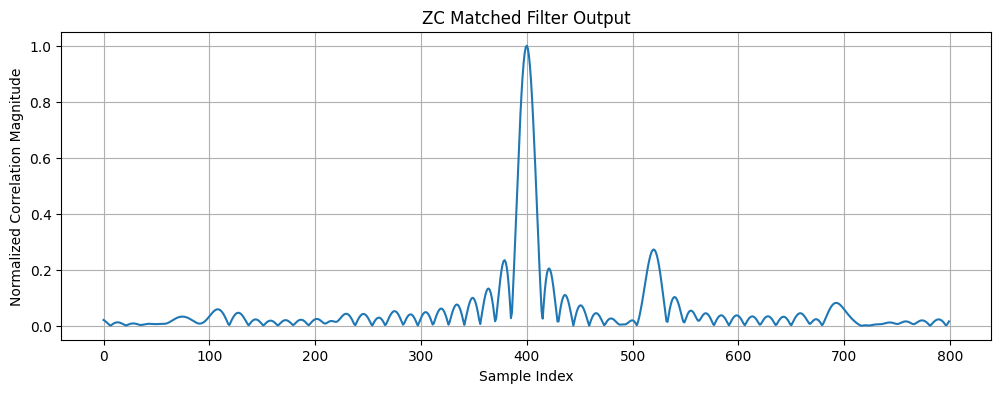

400 3488


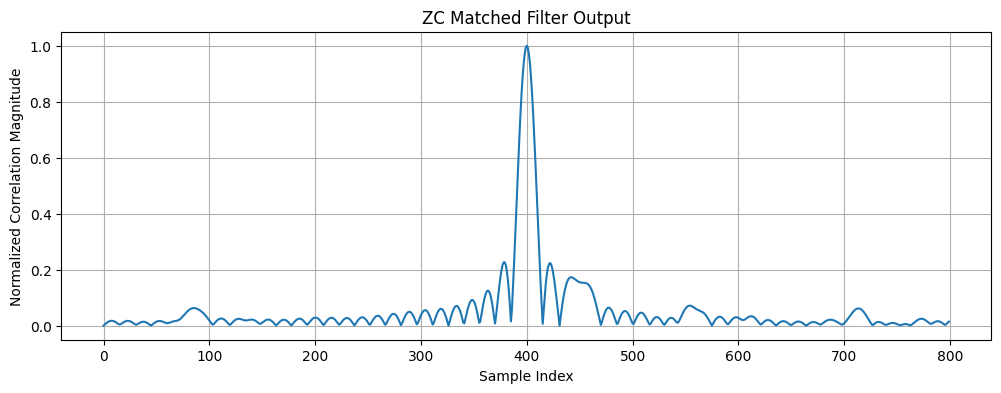

400 3488


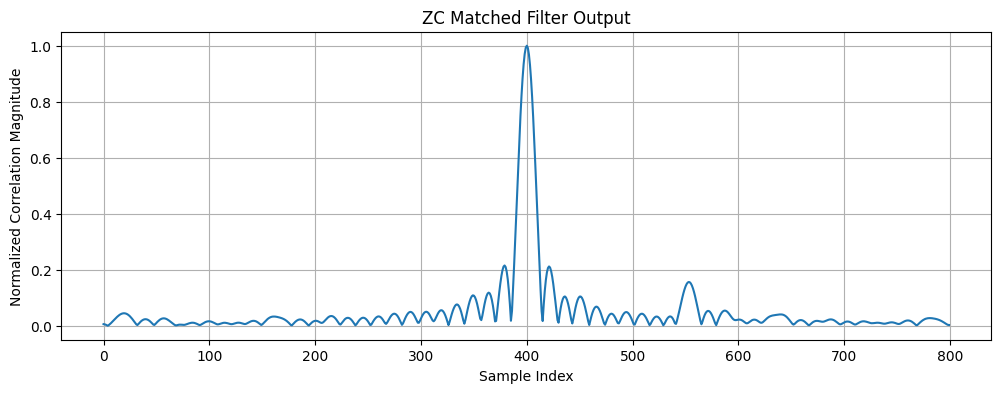

400 3488


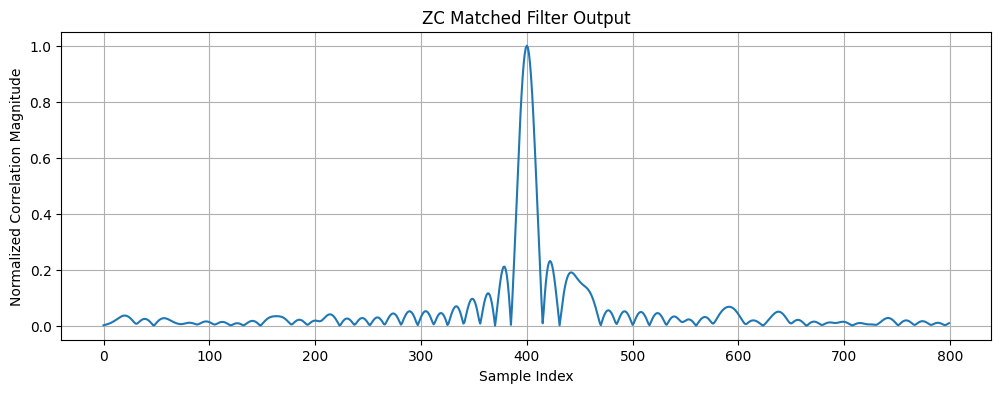

400 3488


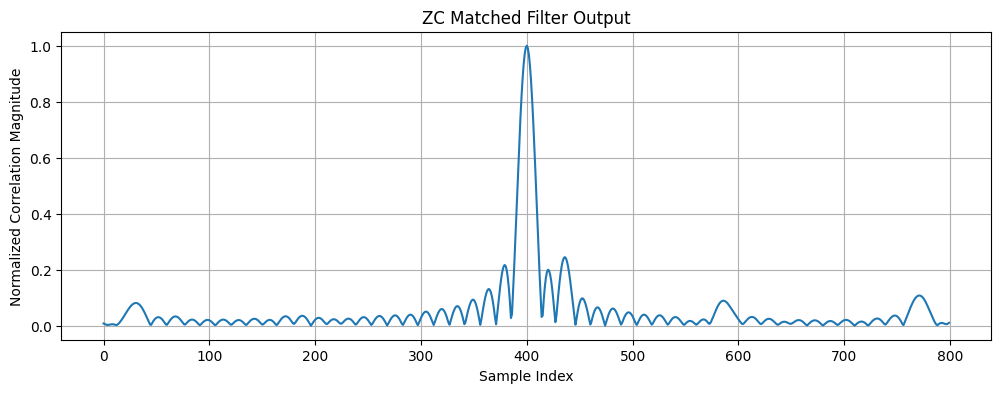

[array([402, 522]), array([402, 444]), array([402, 555]), array([402, 444]), array([402, 438])]


In [26]:
# Extraxting Frames and Detecting LOS and nLOS


LOS_nLOS_samples = []
lengths = [len(x_t1), len(x_t2), len(x_t3), len(x_t4), len(x_t5)]
zc_abbs = [zc_corr_abs1, zc_corr_abs2, zc_corr_abs3, zc_corr_abs4, zc_corr_abs5]


temp = 5

for i in range (temp):
#for i in range (len(unique_samples_list)):
  max_idx1 = np.argmax(zc_abbs[i])
  frame1 = zc_abbs[i][int(max_idx1)- 400 : max_idx1 + 400]
  # Example:
  p_zc_length = lengths[i]
  peak_indices = find_largest_two_peaks(frame1, p_zc_length)
  LOS_nLOS_samples.append(peak_indices)
    # Plot correlation
  plt.figure(figsize=(12, 4))
  plt.plot(frame1)
  plt.title("ZC Matched Filter Output")
  plt.xlabel("Sample Index")
  plt.ylabel("Normalized Correlation Magnitude")
  plt.grid(True)
  plt.show()
print(LOS_nLOS_samples)

In [27]:
# Calculating the distances and comparing with true distances

for i in range(len(LOS_nLOS_samples) ):
  light_speed = 3e8
  peak_indices = LOS_nLOS_samples[i]
  ds = peak_indices[1] - peak_indices[0]
  distance = ds * 1/sample_rate * light_speed

  print("Signal:", str(i+1))
  print("Peak Indices are: ", peak_indices[0], peak_indices[1])
  print("The Peak Difference is: ", ds)
  print("Calculated distance: ",distance)

  NLOS_distance = np.linalg.norm(np.array([0,0,300]) - np.array(anten_location[i][0])) + np.linalg.norm(np.array([0,0,300]) - np.array(anten_location[5][0]))
  LOS_distance = np.linalg.norm(np.array(anten_location[i][0])- np.array(anten_location[5][0]))
  reel_distance = NLOS_distance - LOS_distance

  print("Sample Rate is: ", sample_rate)
  print("Correct distance for Bistatic Time Range: ",reel_distance)
  print(LOS_distance)
  print(NLOS_distance)
  print()


Signal: 1
Peak Indices are:  402 522
The Peak Difference is:  120
Calculated distance:  585.9375
Sample Rate is:  61440000.0
Correct distance for Bistatic Time Range:  588.2313283684905
223.6626924634504
811.8940208319409

Signal: 2
Peak Indices are:  402 444
The Peak Difference is:  42
Calculated distance:  205.078125
Sample Rate is:  61440000.0
Correct distance for Bistatic Time Range:  257.21228324512253
604.1522986797286
861.3645819248511

Signal: 3
Peak Indices are:  402 555
The Peak Difference is:  153
Calculated distance:  747.0703125
Sample Rate is:  61440000.0
Correct distance for Bistatic Time Range:  761.4400830001499
141.77446878757826
903.2145517877282

Signal: 4
Peak Indices are:  402 444
The Peak Difference is:  42
Calculated distance:  205.078125
Sample Rate is:  61440000.0
Correct distance for Bistatic Time Range:  254.1045237802142
604.1729884726725
858.2775122528867

Signal: 5
Peak Indices are:  402 438
The Peak Difference is:  36
Calculated distance:  175.7812499999

In [29]:
# Localization Algorithm that uses 3 best TX's

import numpy as np
from scipy.optimize import least_squares

def localize_with_bistatic(tx_positions, rx_position, path_samples, sample_rate, x0=(0.0, 0.0, 0.0)):
    """
    Solve for target position X (x,y,z) from 3 bistatic ranges:
    |X - tx_i| + |X - rx| = (|tx_i - rx| + c*Δn_i/Fs), i = 0,1,2

    tx_positions : (3,3) array for tx1, tx3, tx5 in this exact order
    rx_position : (3,) array
    path_samples : (3,) array of (NLOS_idx - LOS_idx) for tx1, tx3, tx5
    sample_rate : scalar, Hz (must match waveform Fs)
    x0 : initial guess (x,y,z)

    Returns:
    x_hat : estimated (x,y,z)
    total_lengths : list of total bistatic path lengths for each tx
    residuals_m : residuals [m] at the solution (how well equations fit)
    """
    c = 3e8

    tx_positions = np.asarray(tx_positions, dtype=float).reshape(3,3)
    rx = np.asarray(rx_position, dtype=float).reshape(3,)
    path_samples = np.asarray(path_samples, dtype=float).reshape(3,)

    # LOS distances |tx_i - rx|
    d_tx_rx = np.linalg.norm(tx_positions - rx[None, :], axis=1) # shape (3,)

    # Extra path from sample difference (NLOS - LOS)
    extra_lengths = (path_samples / float(sample_rate)) * c # shape (3,)

    # Total bistatic ranges used in equations
    total_lengths = d_tx_rx + extra_lengths # shape (3,)

    def residuals(p):
        # r_i(p) = |p - tx_i| + |p - rx| - total_lengths[i]
        diffs_tx = np.linalg.norm(p[None, :] - tx_positions, axis=1) # (3,)
        diff_rx = np.linalg.norm(p - rx)
        return diffs_tx + diff_rx - total_lengths

    # Robust least-squares (more stable than fsolve for noisy measurements)
    sol = least_squares(residuals, x0, method='trf', ftol=1e-12, xtol=1e-12, gtol=1e-12, max_nfev=500)

    x_hat = sol.x
    res_m = residuals(x_hat)

    return x_hat, total_lengths.tolist(), res_m.tolist()


# ------------------ Example wiring for your variables ------------------ #
# Use tx1, tx3, tx5 exactly (indices 0, 2, 4 in your anten_location layout).
# Make sure these are the TRANSMITTER coordinates (the first entry in each sublist).

tx1_pos = np.asarray(anten_location[0][0], dtype=float)
tx3_pos = np.asarray(anten_location[2][0], dtype=float)
tx5_pos = np.asarray(anten_location[4][0], dtype=float)

# Your receiver position (single vector, NOT wrapped in an extra list)

rx_pos = np.asarray(anten_location[5][0], dtype=float)


# Build tx array in the order [tx1, tx3, tx5]

txPositions_ex = np.vstack([tx1_pos, tx3_pos, tx5_pos]) # (3,3)


# Sample differences: (NLOS - LOS) for tx1, tx3, tx5, in that order
# Example based on your structure LOS_nLOS_samples[i] = (los_idx, nlos_idx)

pathSamples = np.array([
LOS_nLOS_samples[0][1] - LOS_nLOS_samples[0][0], # tx1
LOS_nLOS_samples[2][1] - LOS_nLOS_samples[2][0], # tx3
LOS_nLOS_samples[4][1] - LOS_nLOS_samples[4][0], # tx5
], dtype=float)


# Solve

x_est, total_paths_m, residuals_m = localize_with_bistatic(
tx_positions=txPositions_ex,
rx_position=rx_pos,
path_samples=pathSamples,
sample_rate=sample_rate, # ensure this is 61.44e6 if that's your PRACH Fs
x0=(0.0, 0.0, 40.0) # good generic initial guess; adjust if needed
)


print("Estimated target (x, y, z) [m]:", x_est)
print("Total bistatic path lengths [m]:", total_paths_m)
print("Residuals at solution [m]:", residuals_m)


Estimated target (x, y, z) [m]: [-10.58009905 -32.11067372 294.27523008]
Total bistatic path lengths [m]: [809.6001924634504, 888.8447812875783, 975.8437475587845]
Residuals at solution [m]: [3.410605131648481e-13, -1.1368683772161603e-13, 1.1368683772161603e-13]


In [30]:
# Uses all of the TX's

import numpy as np
from scipy.optimize import least_squares

# ------------------------------------------------------------
# Core solver: multi-TX bistatic localization (3D or 2D)
# ------------------------------------------------------------
def localize_bistatic_general(
tx_positions,
rx_position,
los_nlos_samples,
sample_rate,
x0=(0.0, 0.0, 0.0),
weights=None,
z_fixed=None, # set to a number (e.g., 0.0) to solve in 2D
loss="soft_l1", # robust loss for outliers
f_scale=1.0, # tune robust loss
):
    """
    Model per transmitter i:
    |X - tx_i| + |X - rx| = |tx_i - rx| + c * Δn_i / Fs
    where Δn_i = (NLOS_idx - LOS_idx)

    Args:
    tx_positions : (N,3) array of transmitter coordinates (meters)
    rx_position : (3,) array of receiver coordinate (meters)
    los_nlos_samples : (N,2) with columns [LOS_idx, NLOS_idx], or (N,) with Δn
    sample_rate : waveform sampling rate Fs (Hz) (e.g., 61.44e6)
    x0 : initial guess (x,y,z)
    weights : optional (N,) weights (e.g., reliability of NLOS peak)
    z_fixed : if not None, solve in 2D with altitude z=z_fixed
    loss, f_scale : robust least_squares options

    Returns:
    x_hat : (3,) estimated target [m]
    used_tx_idx : list of TX indices actually used (valid Δn)
    total_lengths : list of total bistatic lengths [m] for used TX (|tx-rx| + extra)
    residuals_m : list of residuals [m] at solution for used TX
    """
    c = 3e8
    tx_positions = np.asarray(tx_positions, float).reshape(-1, 3)
    rx = np.asarray(rx_position, float).reshape(3,)

    # Accept either Δn vector or (LOS, NLOS) pairs
    los_nlos_samples = np.asarray(los_nlos_samples)
    if los_nlos_samples.ndim == 2 and los_nlos_samples.shape[1] == 2:
        delta_n = los_nlos_samples[:, 1] - los_nlos_samples[:, 0]
    else:
        delta_n = los_nlos_samples.reshape(-1)

    N = tx_positions.shape[0]
    if delta_n.shape[0] != N:
        raise ValueError("los_nlos_samples length must match tx_positions length")

    # Keep only valid Δn (finite and >= 1 sample)
    valid = np.isfinite(delta_n) & (delta_n >= 1)
    used_idx = np.where(valid)[0].tolist()
    if len(used_idx) < (2 if z_fixed is not None else 3):
        raise ValueError(
        f"Insufficient valid NLOS peaks: need >= {2 if z_fixed is not None else 3}, got {len(used_idx)}."
        )

    TX = tx_positions[valid] # (M,3)
    d_tx_rx = np.linalg.norm(TX - rx[None, :], axis=1) # |tx_i - rx|
    extra = (delta_n[valid] / float(sample_rate)) * c # c*Δn/Fs
    total_lengths = d_tx_rx + extra # RHS for each equation

    # Weights
    if weights is not None:
        weights = np.asarray(weights, float).reshape(-1)
        W = weights[valid]
        W = np.where(W > 0, W, 1.0)
    else:
        W = np.ones_like(total_lengths)

    if z_fixed is None:
        # -------- 3D solve --------
        def residuals(p):
            d_tx = np.linalg.norm(p[None, :] - TX, axis=1)
            d_rx = np.linalg.norm(p - rx)
            r = d_tx + d_rx - total_lengths
            return W * r

        x0_use = np.asarray(x0, float).reshape(3,)
        sol = least_squares(residuals, x0_use, loss=loss, f_scale=f_scale,
        method='trf', ftol=1e-12, xtol=1e-12, gtol=1e-12, max_nfev=1000)
        x_hat = sol.x
        res_unweighted = (1.0 / W) * residuals(x_hat) # undo weights for reporting

    else:
        # -------- 2D solve with fixed altitude --------
        zc = float(z_fixed)
        def residuals_xy(pxy):
            p = np.array([pxy[0], pxy[1], zc])
            d_tx = np.linalg.norm(p[None, :] - TX, axis=1)
            d_rx = np.linalg.norm(p - rx)
            r = d_tx + d_rx - total_lengths
            return W * r

        x0_use = np.asarray(x0, float).reshape(3,)
        p0 = np.array([x0_use[0], x0_use[1]])
        sol = least_squares(residuals_xy, p0, loss=loss, f_scale=f_scale,
        method='trf', ftol=1e-12, xtol=1e-12, gtol=1e-12, max_nfev=1000)
        pxy_hat = sol.x
        x_hat = np.array([pxy_hat[0], pxy_hat[1], z_fixed])
        res_unweighted = (1.0 / W) * residuals_xy(pxy_hat)

    return x_hat, used_idx, total_lengths.tolist(), res_unweighted.tolist()


# ------------------------------------------------------------
# Helpers (optional): build inputs from your existing variables
# ------------------------------------------------------------
def build_tx_list_from_anten_location(anten_location, tx_indices):
    """Return (len(tx_indices),3) array of TX positions from your anten_location layout."""
    return np.array([anten_location[i][0] for i in tx_indices], float)

def build_los_nlos_for_tx_indices(LOS_nLOS_samples, tx_indices):
    """Return (len(tx_indices),2) LOS/NLOS array ordered to match tx_indices."""
    return np.array([LOS_nLOS_samples[i] for i in tx_indices], float)


# ------------------------------------------------------------
# EXAMPLE USAGE (edit indices as needed)
# ------------------------------------------------------------
# Choose which entries in anten_location are transmitters you want to use
# (Example: using tx1..tx5 at indices 0..4)
tx_indices = [0, 1, 2, 3, 4]

# Build TX array in that order
tx_all = build_tx_list_from_anten_location(anten_location, tx_indices) # shape (N,3)

# Receiver position (single 3-vector). Adjust index if your RX is elsewhere.
rx_pos = np.array(anten_location[5][0], float)

# LOS/NLOS indices per TX, ordered to match tx_indices
# Expecting LOS_nLOS_samples[i] = (los_idx_i, nlos_idx_i)
los_nlos = build_los_nlos_for_tx_indices(LOS_nLOS_samples, tx_indices)

# Optional per-TX weights (same length as tx_indices). Higher → more trusted.
weights = None
# Example: use correlation peak prominence as weights if you have it:
# weights = np.array([prom_tx1, prom_tx2, prom_tx3, prom_tx4, prom_tx5], float)

# Make sure sample_rate equals your waveform Fs (e.g., 2048*30e3 = 61.44e6)
# sample_rate = Fs

# ---- 3D solve ----
x_est_3d, used_tx_idx_3d, total_paths_m_3d, residuals_m_3d = localize_bistatic_general(
tx_positions=tx_all,
rx_position=rx_pos,
los_nlos_samples=los_nlos, # can also pass Δn vector instead
sample_rate=sample_rate, # e.g., 61_440_000.0
x0=(0.0, 0.0, 40.0),
weights=weights,
z_fixed=None, # <-- 3D
loss="soft_l1",
f_scale=1.0,
)

print("[3D] Estimated target [m]:", x_est_3d)
print("[3D] Used TX indices (relative to tx_indices):", used_tx_idx_3d)
print("[3D] Bistatic path lengths [m]:", total_paths_m_3d)
print("[3D] Residuals [m]:", residuals_m_3d)

# ---- 2D solve (optional, if altitude is known, e.g., z=0.0) ----
# x_est_2d, used_tx_idx_2d, total_paths_m_2d, residuals_m_2d = localize_bistatic_general(
# tx_positions=tx_all,
# rx_position=rx_pos,
# los_nlos_samples=los_nlos,
# sample_rate=sample_rate,
# x0=(0.0, 0.0, 300.0), # x0's z is ignored when z_fixed is not None
# weights=weights,
# z_fixed=0.0, # <-- fix altitude (meters)
# loss="soft_l1",
# f_scale=1.0,
# )
# print("[2D] Estimated target [m]:", x_est_2d)
# print("[2D] Used TX indices (relative to tx_indices):", used_tx_idx_2d)
# print("[2D] Bistatic path lengths [m]:", total_paths_m_2d)
# print("[2D] Residuals [m]:", residuals_m_2d)


[3D] Estimated target [m]: [-15.36947552 -69.15233214 285.40921491]
[3D] Used TX indices (relative to tx_indices): [0, 1, 2, 3, 4]
[3D] Bistatic path lengths [m]: [809.6001924634504, 809.2304236797286, 888.8447812875783, 809.2511134726725, 975.8437475587845]
[3D] Residuals [m]: [9.524534606864336, 2.655900790381793, -1.8560191504196837, -0.5321231596875577, -1.2448358446040402]
